In [30]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.base import clone
# from sklearn.metrics import root_mean_squared_error

from sklearn.metrics import mean_absolute_error

# sklearn.metrics.root_mean_squared_error

from datetime import datetime, timedelta

from IPython.display import clear_output

# Helper Functions

In [31]:
MODEL_ORDER = 2 

In [32]:
def plotSeasonality(df, col) -> None:
    '''
    Plots the Seasonality of Provided [col] on [df]
    returns [void]
    '''
    fig, ax = plt.subplots(2, 3, figsize = (24, 14))

    df.boxplot(column = [col], by = "Month", ax = ax[0, 0])
    ax[0, 1].scatter(df["Month"], df[col])
    ax[0, 2].plot(df.groupby(by = "Month").mean(numeric_only = True)[col].values)
    
    
    df.boxplot(column = [col], by = "Year", ax = ax[1, 0])
    ax[1, 1].scatter(df["Year"], df[col])
    ax[1, 2].plot(df.groupby(by = "Year").mean(numeric_only = True)[col].values)
    
    ax[0, 0].set_title("Month - Box Plot")
    ax[0, 1].set_title("Month - Scatter Plot")
    ax[0, 2].set_title("Month - Average")
    ax[1, 0].set_title("Year - Box Plot")
    ax[1, 1].set_title("Year - Scatter Plot")
    ax[1, 2].set_title("Year - Average")
    
    plt.show()

def plotSeasonalDecomposition(decompose_result):
    fig, ax = plt.subplots(2, 2, figsize = (24, 14))
    observed_series = decompose_result.observed.dropna() 
    trend_series = decompose_result.trend.dropna()
    seasonal_series = decompose_result.seasonal.dropna()
    resid_series = decompose_result.resid.dropna()

    ax[0, 0].plot(observed_series)
    ax[0, 0].set_title("Observed")
    ax[0, 1].plot(trend_series)
    ax[0, 1].set_title("Trend")
    ax[1, 0].plot(seasonal_series)
    ax[1, 0].set_title("Seasonal")
    ax[1, 1].plot(resid_series)
    ax[1, 1].set_title("Residual")

    plt.show()

def multiPeriodSeasonalDecomposition(df, decomposition_mode):
    cols = 5
    rows = df.shape[0] // 2 // cols + 1

    # Trend
    fig, trend_ax = plt.subplots(rows, cols, figsize = (24, rows * 3))
    fig, seasonal_ax = plt.subplots(rows, cols, figsize = (24, rows * 3))
    fig, resid_ax = plt.subplots(rows, cols, figsize = (24, rows * 3))

    lowest_val = min(yearly_df["means"]) - 1
    highest_val = min(yearly_df["means"]) + 2

    for i in range(1, yr.shape[0] // 2 + 1):
        try:
            ysd = seasonal_decompose(yearly_df["means"], model = decomposition_mode, period = i)
            x = i % cols 
            y = i // cols 

            seasonal_ax[y, x].plot(ysd.seasonal)
            seasonal_ax[y, x].set_title(i)

            trend_ax[y, x].plot(ysd.trend)
            trend_ax[y, x].set_title(i)
            trend_ax[y, x].set_ylim([lowest_val, highest_val])

            resid_ax[y, x].plot(ysd.resid)
            resid_ax[y, x].hlines(ysd.resid.mean(), ysd.resid.index[0], ysd.resid.index[-1], color = "red", alpha = 0.3)
            resid_ax[y, x].set_title(i)

        except Exception as E:
            print("Error at i:", i, "Error:", E)

    # clear_output()
    plt.show()

def plotPredsTest(preds, test_y):
    plt.figure(figsize = (24, 7))
    plt.scatter(np.arange(0, len(preds)), preds, alpha = 0.5, label = "Predictions")
    plt.scatter(np.arange(0, len(test_y)), test_y, label="Actual")
    plt.plot(preds, alpha = 0.5, label = "Prediction Lines")
    plt.plot(test_y, label = "Actual Lines")
    plt.legend()
    plt.show()

In [33]:
def removeYearlyMean(df, col, YEAR_LENGTH = 7):
    MODEL_YEARLY_STD = None 
    YEARLY_SEASONALITY_LENGTH = YEAR_LENGTH

    normalized_yearly_df = df.copy()
    normalized_yearly_df["YearMod"] = normalized_yearly_df[col]

    years = pd.DatetimeIndex(normalized_yearly_df["datetime"]).year.unique().to_list()
    min_val = years[0]
    years_normalized = [(x - min_val) % YEARLY_SEASONALITY_LENGTH for x in years]
    normalized_yearly_df["YearAug"] = (pd.DatetimeIndex(normalized_yearly_df["datetime"]).year - min_val) % YEARLY_SEASONALITY_LENGTH

    yr_grp = normalized_yearly_df.groupby(by = "YearAug").mean(numeric_only = True)[col]

    for year in normalized_yearly_df["YearAug"].unique():
        normalized_yearly_df.loc[normalized_yearly_df["YearAug"] == year, "YearMod"] -= yr_grp[year]
        # normalized_yearly_df.loc[normalized_yearly_df["YearAug"] == year, "YearMod"] /= yr_grp[year]

    yearly_mean = normalized_yearly_df["YearMod"].mean()
    normalized_yearly_df["YearMod"] = normalized_yearly_df["YearMod"] - yearly_mean
    # normalized_yearly_df["YearMod"] = normalized_yearly_df["YearMod"] / yearly_mean

    MODEL_YEARLY_STD = np.std(normalized_yearly_df["YearMod"])

    return MODEL_YEARLY_STD, yearly_mean, min_val, yr_grp, normalized_yearly_df

In [34]:
def removeMonthlyMean(df):
    normalized_df = df.copy()
    normalized_df["MonthMod"] = normalized_df["YearMod"]

    month_grp = normalized_df.groupby(by = "Month").mean(numeric_only = True)["MonthMod"]

    for month in normalized_df['Month'].unique():
        # Look for df["Month"] == current unique month, Change TempMod Value to be (currentTemp of the Day) - (Monthly Mean)
        normalized_df.loc[normalized_df['Month'] == month, "MonthMod"] -= month_grp[month]

    monthly_mean = normalized_df['MonthMod'].mean()

    # Subtract the Normalized Temperature Mean by the Total Mean of all the other Normalized
    normalized_df['MonthMod'] = normalized_df['MonthMod'] - monthly_mean

    return normalized_df, month_grp, monthly_mean


In [35]:
def window_data(data):
    n = len(data)
    x = []
    y = []
    for i in range(n - MODEL_ORDER):
        x.append(data[i : i + MODEL_ORDER])
        y.append(data[i + MODEL_ORDER])
    
    return np.array(x), np.array(y)

In [36]:
def splitData(df, split_percent = 70):
    train_data = df["MonthMod"].copy()
    n = len(train_data)
    split_point = int(split_percent / 100 * n)

    MODEL_SIGMA = np.std(train_data[:split_point])
    window_x, window_y = window_data(train_data)

    train_x = window_x[:split_point]
    test_x = window_x[split_point:]
    train_y = window_y[:split_point]
    test_y = window_y[split_point:]

    return (train_x, test_x, train_y, test_y), MODEL_SIGMA

In [37]:
def calculatePredictionDate(normalized_df, train_y, YEAR, MONTH, DATE, MODEL_ORDER):
    target_date = datetime(YEAR, MONTH, DATE)
    
    StringFormat = "%Y-%M-%d"
    raw_start_date = normalized_df["datetime"][MODEL_ORDER].date()
    
    train_start_date = raw_start_date
    train_end_date = train_start_date + timedelta(days = len(train_y)) # + 1 Since Range

    prediction_start_date = train_end_date # -1 + 1
    prediction_end_date = target_date + timedelta(days = 1)

    prediction_date_range = np.arange(prediction_start_date, prediction_end_date, timedelta(days = 1)).astype("datetime64[D]")
    prediction_length = len(prediction_date_range)

    return prediction_date_range, prediction_length


In [38]:
def calculateTrainingDateRange(df, train_y, MODEL_ORDER):
    StringFormat = "%Y-%M-%d"
    raw_start_date = df["datetime"][MODEL_ORDER]
    train_start_date = datetime.strptime(raw_start_date, StringFormat)
    train_end_date = train_start_date + timedelta(days = len(train_y)) # + 1 Since Range <

    training_date_range = np.arange(train_start_date, train_end_date, timedelta(days = 1)).astype("datetime64[D]")

    return training_date_range

In [39]:
def trainModel(predictorClass, train_x, train_y):
    MODEL_PREDICTOR = clone(predictorClass)
    MODEL_PREDICTOR.fit(train_x, train_y)

    return MODEL_PREDICTOR

In [40]:
def doPredictions(train_x, num_predictions, MODEL_ORDER, MONTH_STD, MONTH_STD_SCALE, YEAR_STD, YEAR_STD_SCALE, MODEL_PREDICTOR):
    preds = np.array([])
    r_queue = np.copy(train_x)[-MODEL_ORDER]
    
    for i in tqdm(range(num_predictions)):
        tr = np.reshape(r_queue, (1, -1))
        month_resid = np.random.normal(loc = 0, scale = MONTH_STD * MONTH_STD_SCALE)
        year_resid = np.random.normal(loc = 0, scale = YEAR_STD * YEAR_STD_SCALE)
        next_val = MODEL_PREDICTOR.predict(tr) + month_resid + year_resid 
        # next_val = MODEL_PREDICTOR.predict(tr) + month_resid * year_resid 
        preds = np.append(preds, next_val)
        r_queue = np.roll(r_queue, -1)
        r_queue[-1] = next_val

    return preds 

In [41]:
def reconstructDF(prediction_date_range, training_date_range, preds, train_y, month_grp, year_grp, year_min_val, monthly_mean, yearly_mean, YEARLY_SEASONALITY_LENGTH):
    full_datetime_range = np.concatenate((training_date_range, prediction_date_range))
    concatenated_preds = np.concatenate((train_y, preds))

    constructed_df = pd.DataFrame({
        "datetime" : full_datetime_range,
        "PredictionFull" : concatenated_preds
    })

    constructed_df["Month"] = pd.DatetimeIndex(constructed_df["datetime"]).month
    constructed_df["Year"] = pd.DatetimeIndex(constructed_df["datetime"]).year 

    constructed_df["YearAug"] = (constructed_df["Year"] - year_min_val) % YEARLY_SEASONALITY_LENGTH

    constructed_df["ReconMonth"] = constructed_df["PredictionFull"]

    for month in constructed_df["Month"].unique():
        constructed_df.loc[constructed_df['Month'] == month, "ReconMonth"] += month_grp[month]

    constructed_df["ReconMonth"] += monthly_mean 

    constructed_df["ReconstructedFinal"] = constructed_df["ReconMonth"]

    for year in constructed_df["YearAug"].unique():
        constructed_df.loc[constructed_df["YearAug"] == year, "ReconstructedFinal"] += year_grp[year]
        # constructed_df.loc[constructed_df["YearAug"] == year, "ReconstructedFinal"] *= year_grp[year]

    # constructed_df["ReconstructedFinal"] *= yearly_mean
    constructed_df["ReconstructedFinal"] += yearly_mean

    return constructed_df


In [42]:
def evaluatePredictions(finalDF, normalized_df, col, train_percent = 70):
    final_train_idx = int(normalized_df.shape[0] * train_percent / 100)
    final_train_datetime_val = normalized_df.loc[idx, "datetime"]
    finalDF_train_last_idx = finalDF.loc[finalDF["datetime"] == final_train_datetime_val].index[0] 
    normalizedDF_train_last_idx = normalized_df.loc[normalized_df["datetime"] == final_train_datetime_val].index
    y_preds = finalDF[finalDF_train_last_idx + MODEL_ORDER : finalDF_train_last_idx + normalized_df.shape[0] - normalizedDF_train_last_idx[0]]["ReconstructedFinal"].values
    y_true = normalized_df[normalizedDF_train_last_idx[0] + MODEL_ORDER : normalized_df.shape[0]][col].values

    return mean_absolute_error(y_true, y_preds)

# Single Pass

In [43]:
def singlePass(col = "temp", myss = 0, ysl = 7, mmss = 1, sp = 70, mo = 2, py = 2050, pm = 12, pd = 31):
    temperature_df = df[["datetime", col, "Month", "Year"]].copy()
    MODEL_YEARLY_STD_SCALE = myss 
    YEARLY_SEASON_LENGTH = ysl
    MODEL_YEARLY_STD, yearly_mean, year_min_val, year_grp, normalized_yearly_df = removeYearlyMean(temperature_df, col, YEARLY_SEASON_LENGTH)
    normalized_df, month_grp, monthly_mean = removeMonthlyMean(normalized_yearly_df)
    MODEL_ORDER = mo
    MODEL_MONTHLY_STD_SCALE = mmss
    SPLIT_POINT = sp
    (train_x, test_x, train_y, test_y), MODEL_MONTHLY_STD = splitData(normalized_df, SPLIT_POINT)
    PREDICTOR = trainModel(LinearRegression(), train_x, train_y)
    YEAR = py
    MONTH = pm
    DATE = pd

    prediction_date_range, prediction_length = calculatePredictionDate(normalized_df, train_y, YEAR, MONTH, DATE, MODEL_ORDER)
    training_date_range = calculateTrainingDateRange(normalized_df, train_y, MODEL_ORDER)
    
    predictions = doPredictions(train_x, prediction_length, MODEL_ORDER, MODEL_MONTHLY_STD, MODEL_MONTHLY_STD_SCALE, MODEL_YEARLY_STD, MODEL_YEARLY_STD_SCALE, PREDICTOR)
    finalDF = reconstructDF(prediction_date_range, training_date_range, predictions, train_y, month_grp, year_grp, year_min_val, monthly_mean, yearly_mean, YEARLY_SEASON_LENGTH)
    mae = evaluatePredictions(finalDF, normalized_df, col, SPLIT_POINT)

    return mae, finalDF

# Single Pass with Graph

In [44]:
def singlePassWithGraph(col, YearScale, MonthScale, ModelOrder):
    MODEL_ORDER = 3
    mae, finalDF = singlePass(myss = YearScale, mmss = MonthScale, col=col, sp = 1, mo = ModelOrder)

    plt.figure(figsize = (24, 7))
    plt.title(col + " Predictions")
    plt.plot(finalDF["ReconstructedFinal"].values, label = "Predictions")
    plt.plot(df[col].values[ModelOrder:], label = "Actual")
    plt.legend()
    plt.show()

# Obtain Raw Data

In [45]:
raw_data = pd.read_csv("1989 to 2023 CombinedData.csv")
df = raw_data.copy()
df["Month"] = pd.DatetimeIndex(df["datetime"]).month 
df["Year"] = pd.DatetimeIndex(df["datetime"]).year

# Temperature 

In [46]:
singlePassWithGraph("temp", 0.2, 0.5, 3)

AttributeError: 'str' object has no attribute 'date'

100%|██████████| 22515/22515 [00:03<00:00, 5911.79it/s]


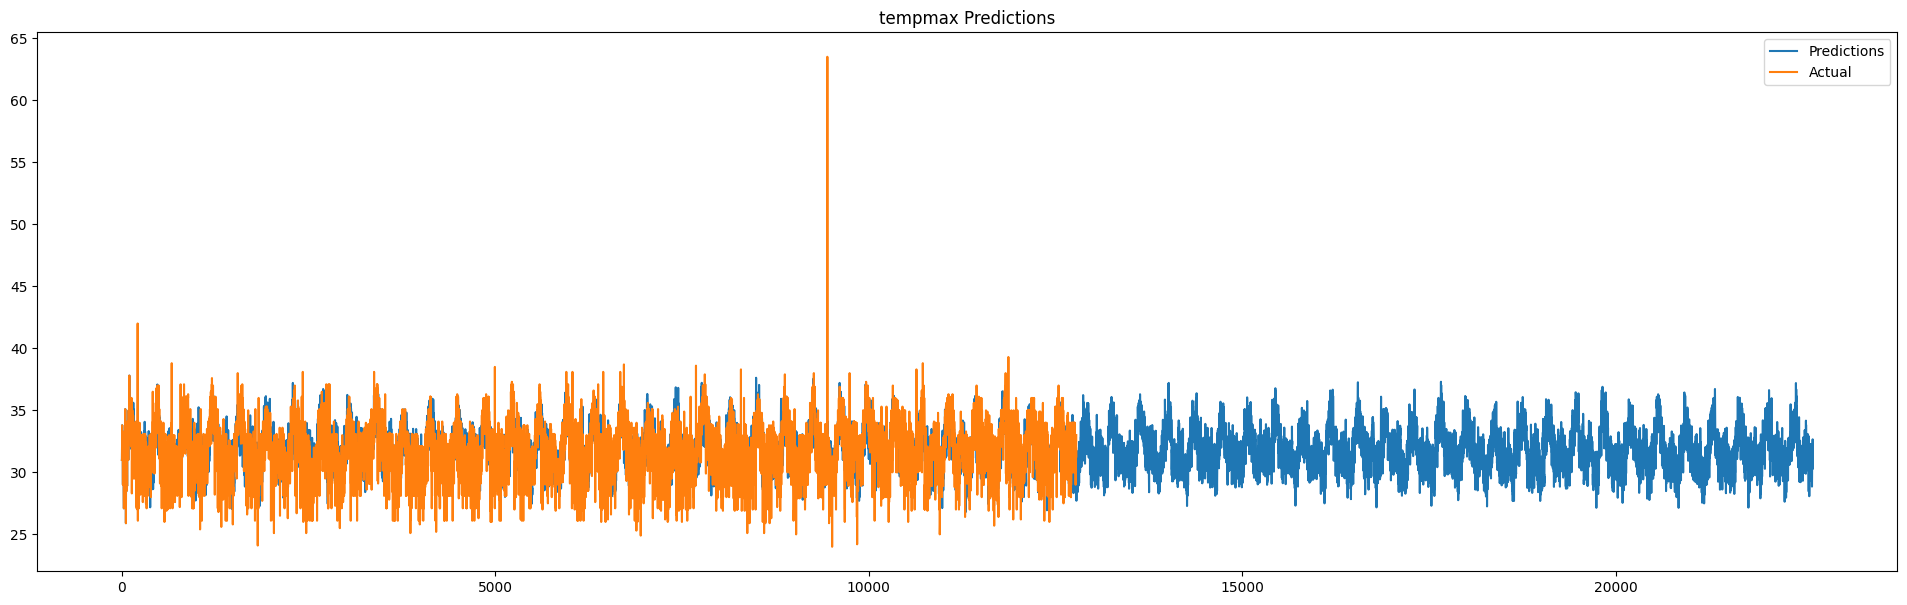

In [ ]:
singlePassWithGraph("tempmax", 0.2, 0.5, 3)

100%|██████████| 22515/22515 [00:03<00:00, 6341.39it/s]


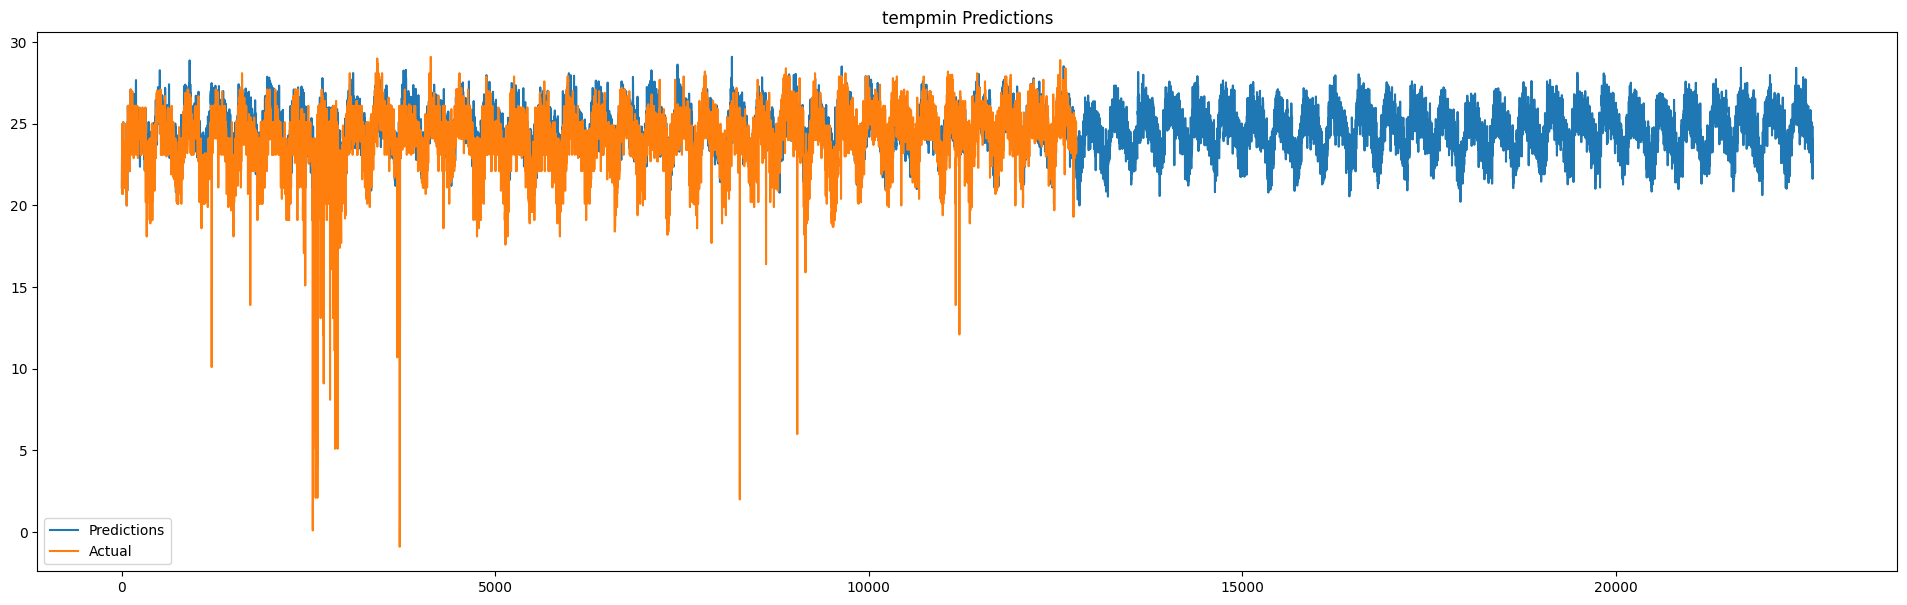

In [ ]:
singlePassWithGraph("tempmin", 0.2, 0.5, 3)

100%|██████████| 22515/22515 [00:03<00:00, 5643.38it/s]


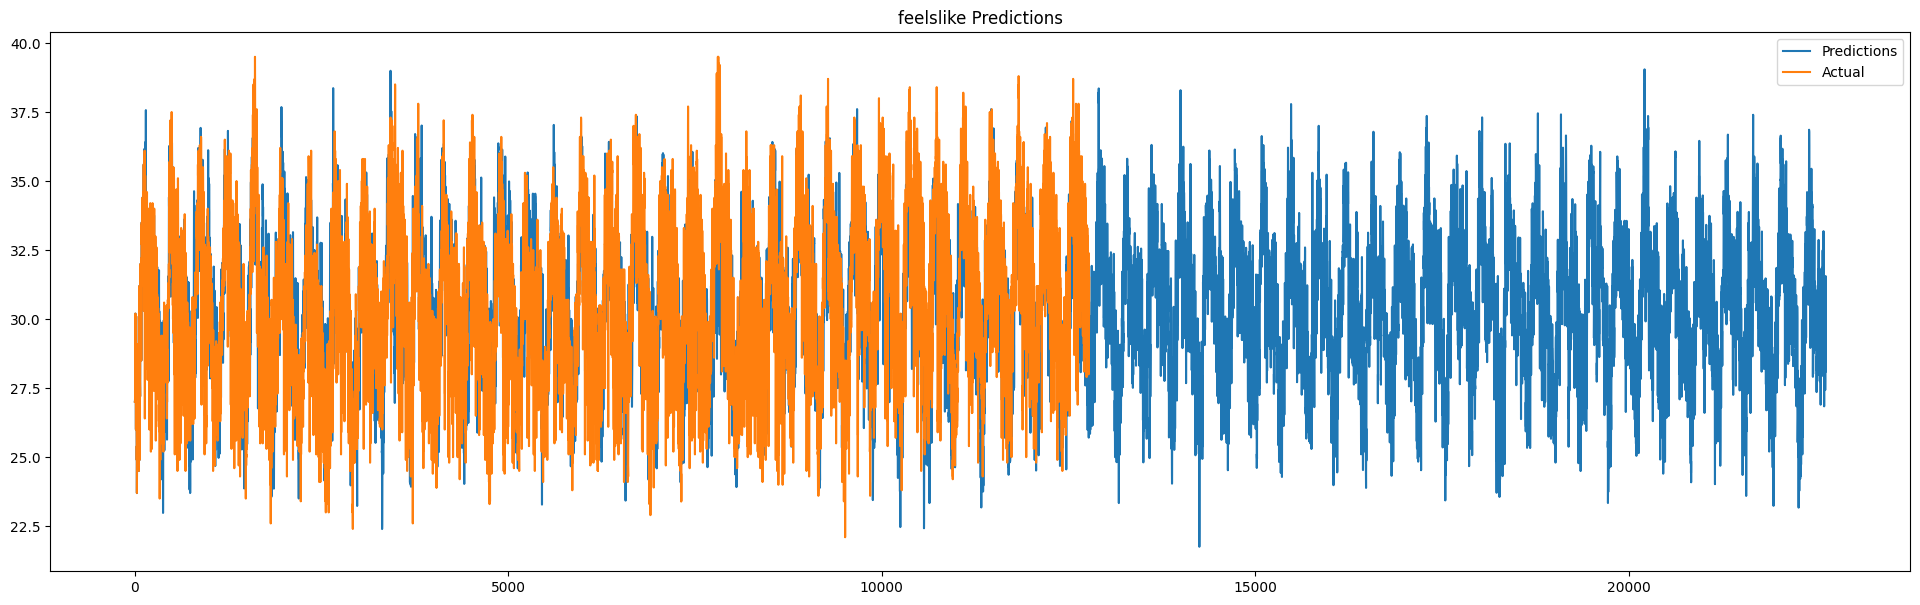

In [ ]:
singlePassWithGraph("feelslike", 0.2, 0.5, 3)

100%|██████████| 22515/22515 [00:03<00:00, 5978.43it/s]


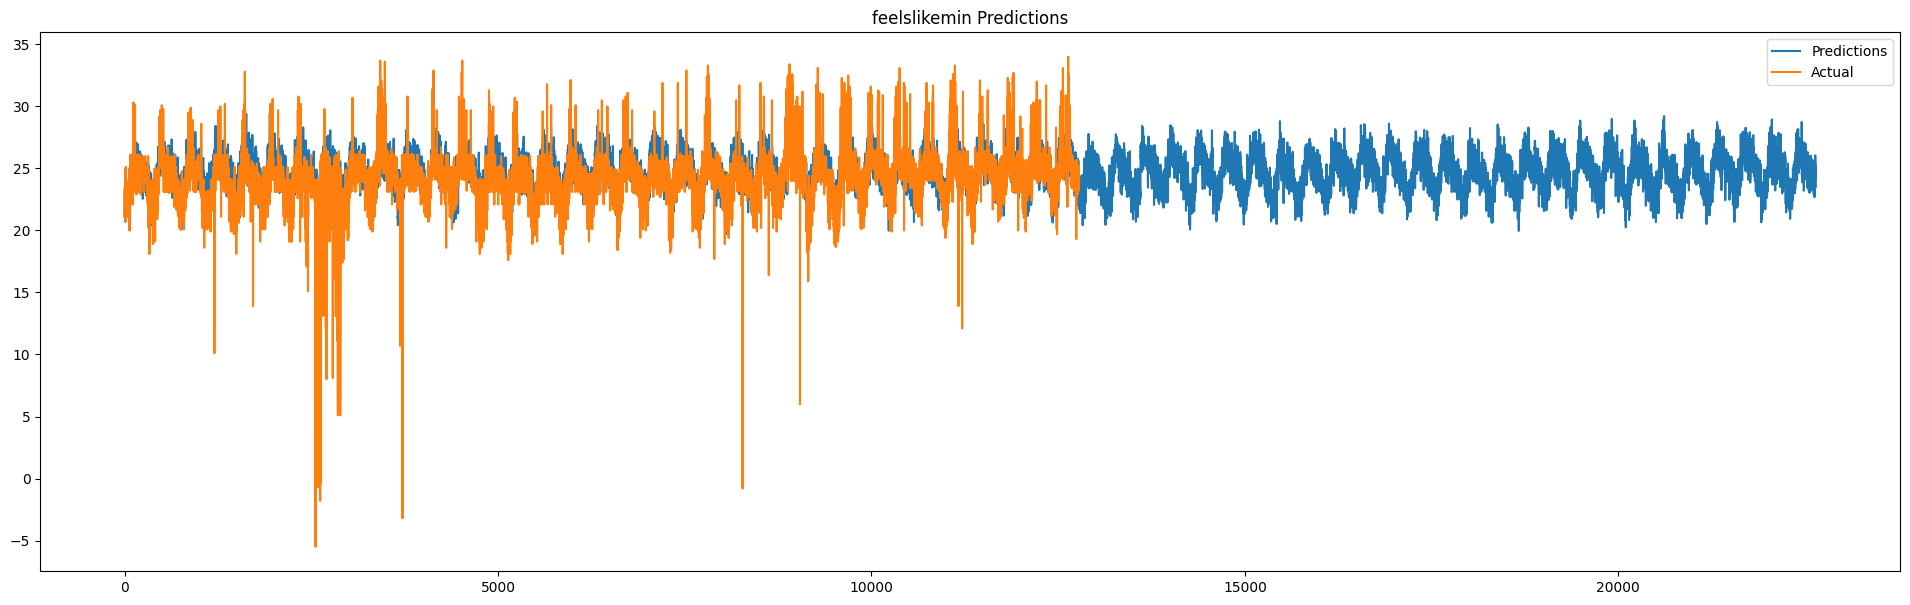

In [ ]:
singlePassWithGraph("feelslikemin", 0.2, 0.5, 3)

100%|██████████| 22515/22515 [00:03<00:00, 6082.10it/s]


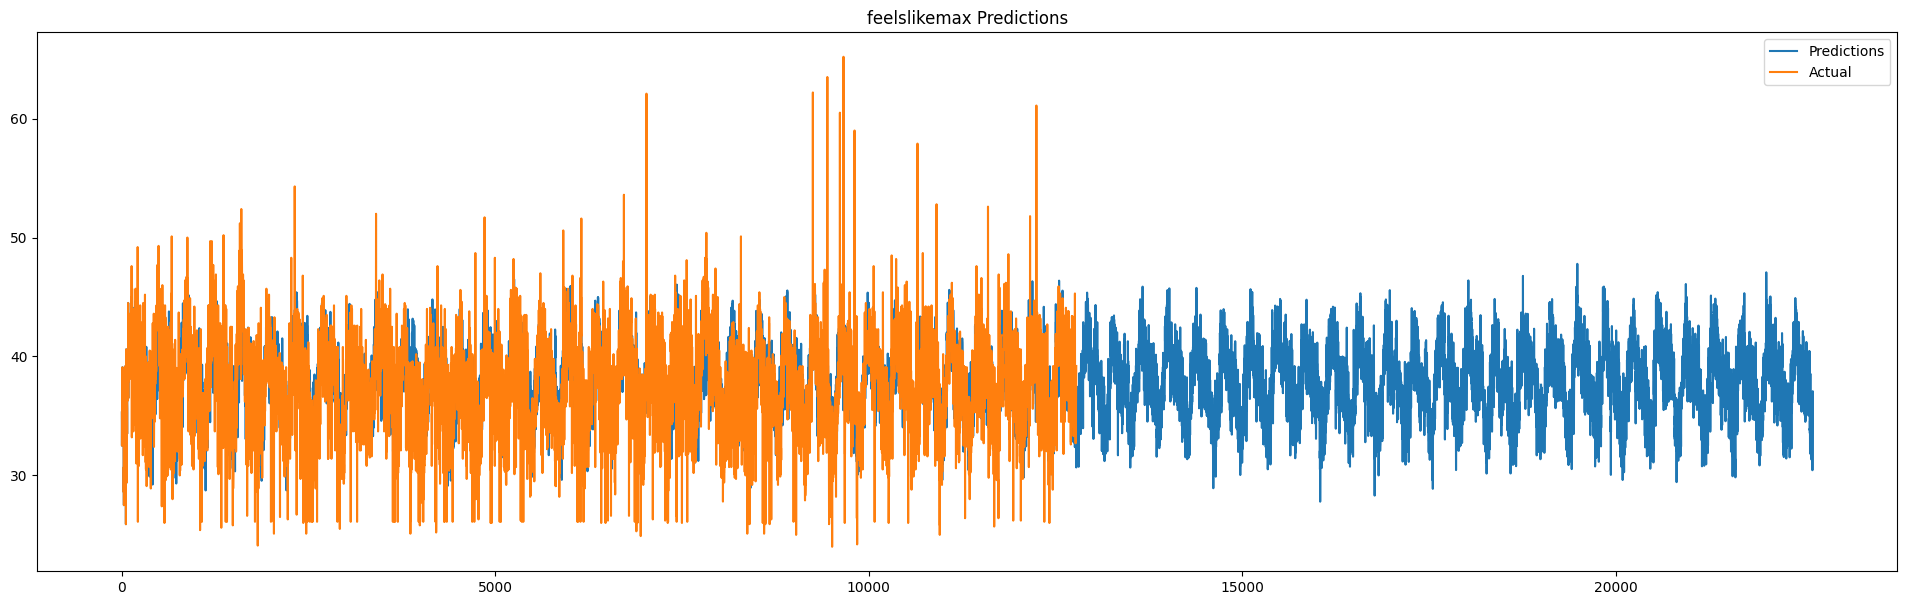

In [ ]:
singlePassWithGraph("feelslikemax", 0.2, 0.5, 3)

100%|██████████| 22515/22515 [00:03<00:00, 6531.62it/s]


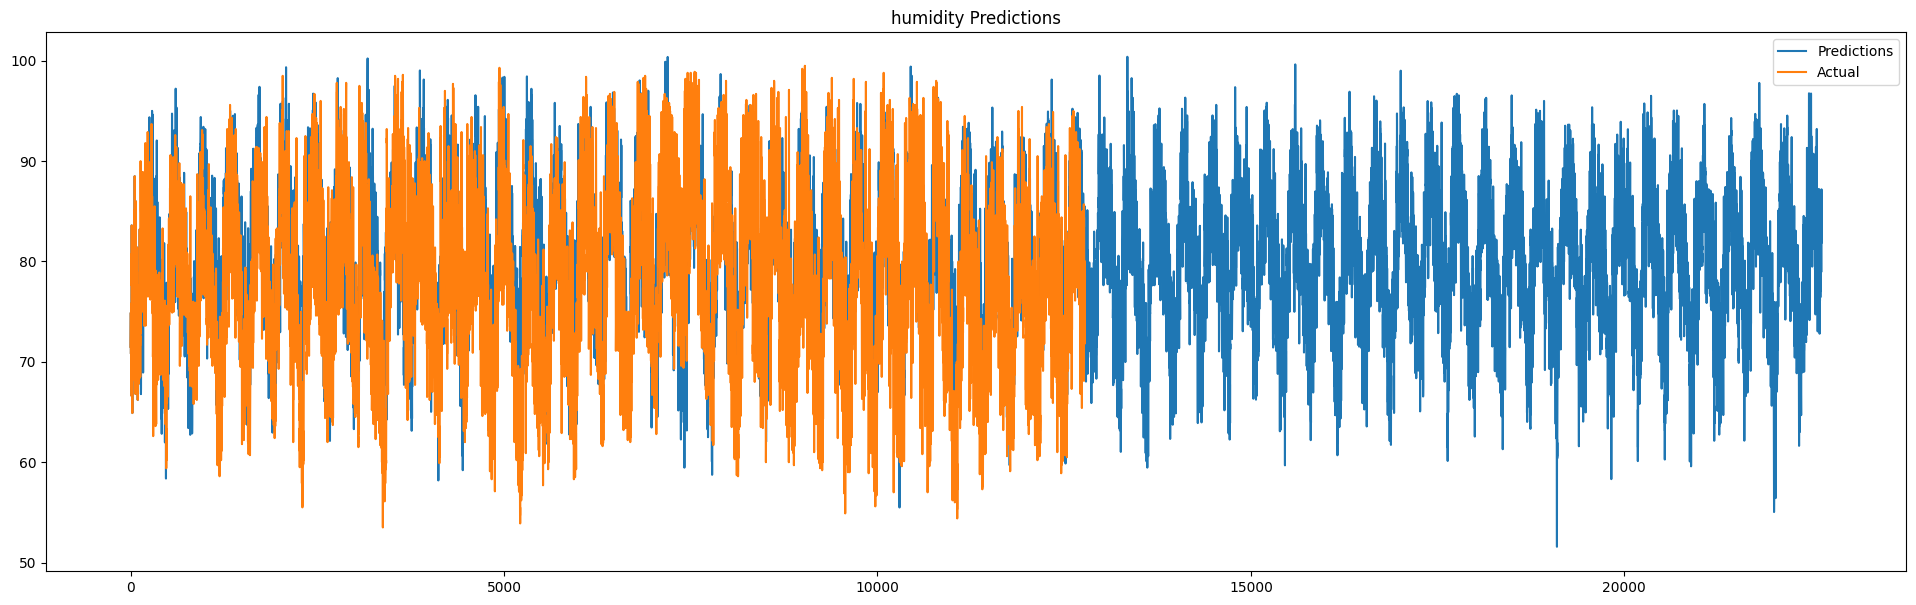

In [ ]:
singlePassWithGraph("humidity", 0.2, 0.5, 3)

100%|██████████| 22515/22515 [00:03<00:00, 6123.99it/s]


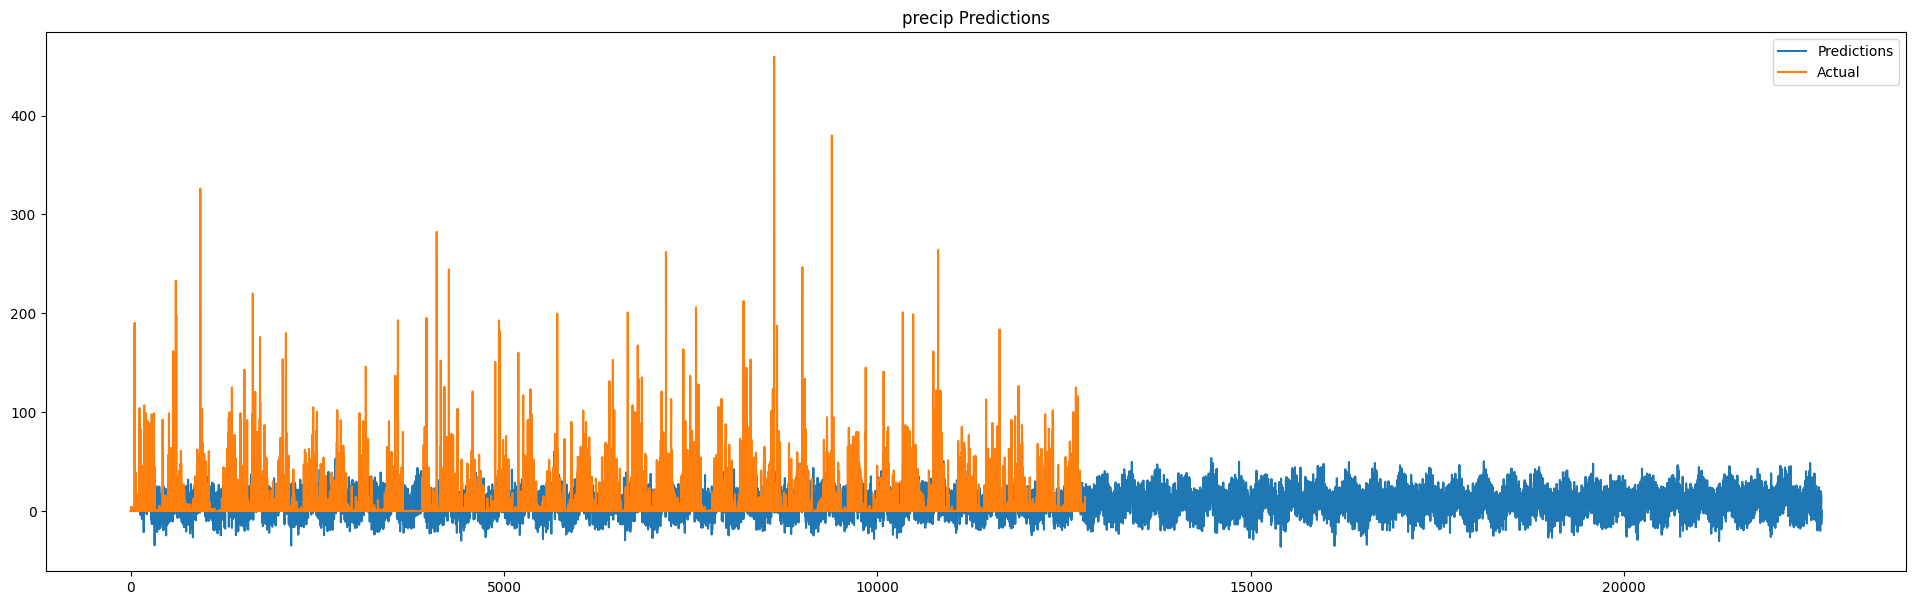

In [ ]:
singlePassWithGraph("precip", 0.2, 0.5, 3)

100%|██████████| 22515/22515 [00:03<00:00, 6626.95it/s]


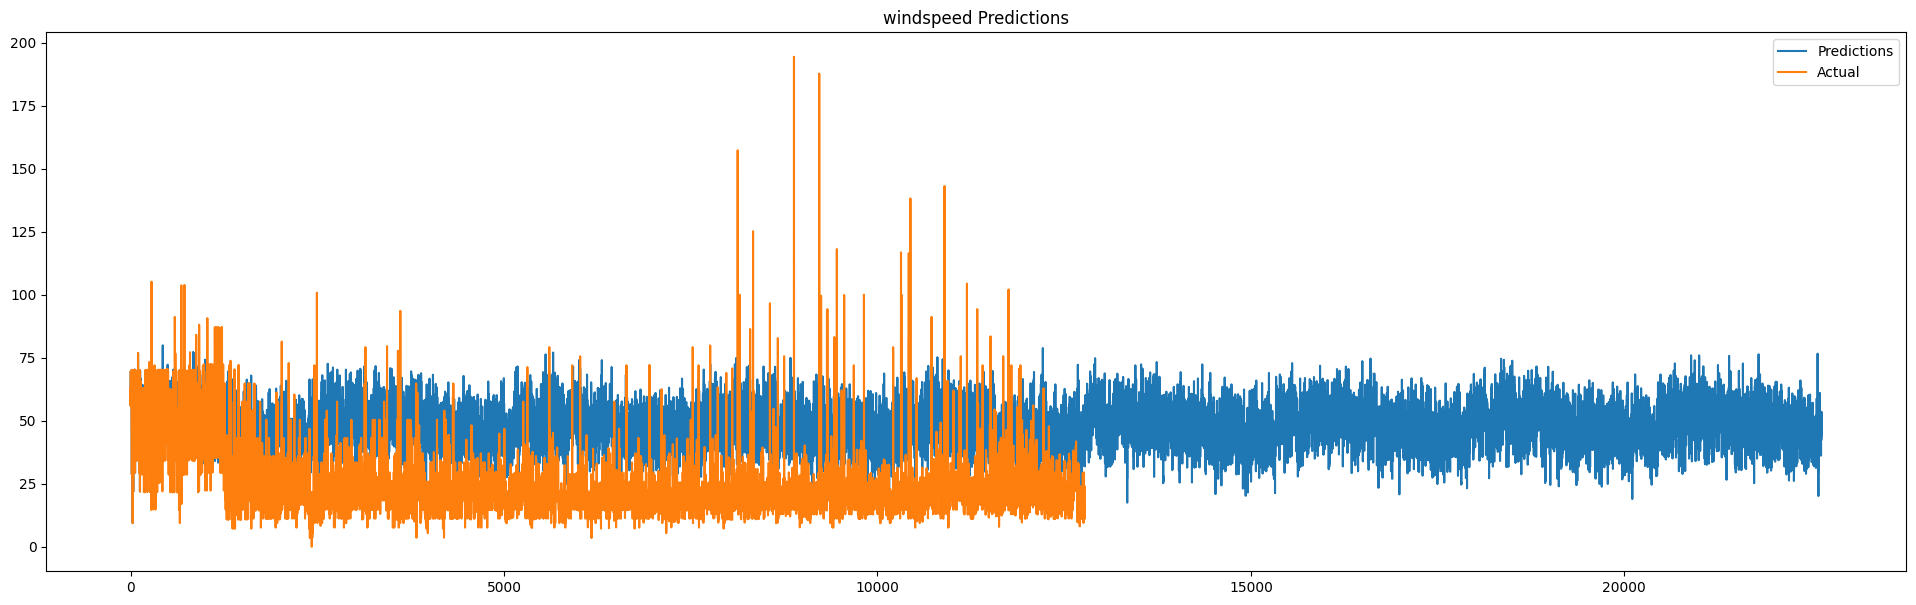

In [ ]:
singlePassWithGraph("windspeed", 0.2, 0.5, 3)